In [145]:
# Import findspark
import findspark
findspark.init()

In [146]:
# Import the required modules
import pandas as pd
from pathlib import Path
import hvplot.pandas

# Import packages
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.types import StructType,StructField,StringType, DateType,IntegerType
from pyspark import SparkFiles

# Create a SparkSession
spark = SparkSession.builder.appName("HeartView").getOrCreate()

In [147]:

# Read data directly from a github repo.
url='https://raw.githubusercontent.com/cscar43/Project_4/main/Resources/cleaned_data.csv'

In [148]:

spark.sparkContext.addFile(url)
heart_data = spark.read.option('header', 'true').csv(SparkFiles.get("cleaned_data.csv"), inferSchema=True, sep=',', timestampFormat="mm/dd/yy")

# Show DataFrame
heart_data.show()

+------+---+--------------+----------------+----------------------+--------+-----------------+-----------------------+------------------------+-----+----------+------------+
|gender|age|current_smoker|prevalent_stroke|prevalent_hypertension|diabetes|total_cholesterol|systolic_blood_pressure|diastolic_blood_pressure|  bmi|heart_rate|heart_stroke|
+------+---+--------------+----------------+----------------------+--------+-----------------+-----------------------+------------------------+-----+----------+------------+
|  Male| 39|             0|              no|                     0|       0|            195.0|                  106.0|                    70.0|26.97|      80.0|          No|
|Female| 46|             0|              no|                     0|       0|            250.0|                  121.0|                    81.0|28.73|      95.0|          No|
|  Male| 48|             1|              no|                     0|       0|            245.0|                  127.5|            

23/08/01 21:10:42 WARN SparkContext: The path https://raw.githubusercontent.com/cscar43/Project_4/main/Resources/cleaned_data.csv has been added already. Overwriting of added paths is not supported in the current version.


In [149]:
heart_data_df = heart_data.toPandas()
heart_data_df.head()

,gender,age,current_smoker,prevalent_stroke,prevalent_hypertension,diabetes,total_cholesterol,systolic_blood_pressure,diastolic_blood_pressure,bmi,heart_rate,heart_stroke
0,Male,39,0,no,0,0,195.0,106.0,70.0,26.97,80.0,No
1,Female,46,0,no,0,0,250.0,121.0,81.0,28.73,95.0,No
2,Male,48,1,no,0,0,245.0,127.5,80.0,25.34,75.0,No
3,Female,61,1,no,1,0,225.0,150.0,95.0,28.58,65.0,yes
4,Female,46,1,no,0,0,285.0,130.0,84.0,23.10,85.0,No


In [150]:
columns_to_dummify = ["gender", "prevalent_stroke", "heart_stroke"]
# Use pd.get_dummies() on the selected columns
heart_dum = pd.get_dummies(heart_data_df[columns_to_dummify])

heart_dum.head()

,gender_Female,gender_Male,prevalent_stroke_no,prevalent_stroke_yes,heart_stroke_No,heart_stroke_yes
0,0,1,1,0,1,0
1,1,0,1,0,1,0
2,0,1,1,0,1,0
3,1,0,1,0,0,1
4,1,0,1,0,1,0


In [151]:
heart_data_df = pd.concat([heart_data_df, heart_dum], axis=1)

# Drop the original education column
heart_data_df = heart_data_df.drop(columns=["gender", "prevalent_stroke", "heart_stroke"])

heart_data_df.head()

,age,current_smoker,prevalent_hypertension,diabetes,total_cholesterol,systolic_blood_pressure,diastolic_blood_pressure,bmi,heart_rate,gender_Female,gender_Male,prevalent_stroke_no,prevalent_stroke_yes,heart_stroke_No,heart_stroke_yes
0,39,0,0,0,195.0,106.0,70.0,26.97,80.0,0,1,1,0,1,0
1,46,0,0,0,250.0,121.0,81.0,28.73,95.0,1,0,1,0,1,0
2,48,1,0,0,245.0,127.5,80.0,25.34,75.0,0,1,1,0,1,0
3,61,1,1,0,225.0,150.0,95.0,28.58,65.0,1,0,1,0,0,1
4,46,1,0,0,285.0,130.0,84.0,23.10,85.0,1,0,1,0,1,0


In [152]:
# Import the module
from sklearn.preprocessing import StandardScaler

In [153]:
# Scaling the numeric columns
heart_data_scaled = StandardScaler().fit_transform(heart_data_df[["age", "total_cholesterol", "systolic_blood_pressure", "diastolic_blood_pressure", "bmi", "heart_rate"]])

# Review the scaled data
heart_data_scaled

array([[-1.23469876, -0.93688293, -1.19781851, -1.08622077,  0.28819812,
         0.34464389],
       [-0.41544966,  0.29645369, -0.51449813, -0.16037163,  0.71984643,
         1.59044191],
       [-0.18137849,  0.18433217, -0.21839263, -0.24453973, -0.11156707,
        -0.07062212],
       ...,
       [-0.18137849,  0.25160508, -0.0589512 , -0.91788456, -0.93071784,
         0.6768567 ],
       [-0.64952083, -0.6005184 , -0.26394732,  0.34463699, -1.62724124,
         0.8429631 ],
       [ 0.28676386,  0.72251543,  0.05493553,  0.00796458, -1.06070284,
         0.34464389]])

In [154]:
# Create a DataFrame of the scaled data
heart_data_scaled = pd.DataFrame(heart_data_scaled, columns=["age", "total_cholesterol", "systolic_blood_pressure", "diastolic_blood_pressure", "bmi", "heart_rate"])

# Replace the original data with the columns of information from the scaled Data
heart_data_df["age"] = heart_data_scaled["age"]
heart_data_df["total_cholesterol"] = heart_data_scaled["total_cholesterol"]
heart_data_df["systolic_blood_pressure"] = heart_data_scaled["systolic_blood_pressure"]
heart_data_df["diastolic_blood_pressure"] = heart_data_scaled["diastolic_blood_pressure"]
heart_data_df["bmi"] = heart_data_scaled["bmi"]
heart_data_df["heart_rate"] = heart_data_scaled["heart_rate"]

# Review the DataFrame
heart_data_df.head()

,age,current_smoker,prevalent_hypertension,diabetes,total_cholesterol,systolic_blood_pressure,diastolic_blood_pressure,bmi,heart_rate,gender_Female,gender_Male,prevalent_stroke_no,prevalent_stroke_yes,heart_stroke_No,heart_stroke_yes
0,-1.234699,0,0,0,-0.936883,-1.197819,-1.086221,0.288198,0.344644,0,1,1,0,1,0
1,-0.415450,0,0,0,0.296454,-0.514498,-0.160372,0.719846,1.590442,1,0,1,0,1,0
2,-0.181378,1,0,0,0.184332,-0.218393,-0.244540,-0.111567,-0.070622,0,1,1,0,1,0
3,1.340084,1,1,0,-0.264154,0.806588,1.017982,0.683058,-0.901154,1,0,1,0,0,1
4,-0.415450,1,0,0,1.081304,-0.104506,0.092133,-0.660938,0.759910,1,0,1,0,1,0


In [155]:
heart_data_df.drop(['prevalent_stroke_no', 'heart_stroke_No', 'gender_Male'], axis=1, inplace=True)

In [156]:
heart_data_df.rename(columns={'prevalent_stroke_yes': 'prevalent_stroke', 'heart_stroke_yes': 'heart_stroke', 'gender_Female': 'gender'}, inplace=True)

heart_data_df.head()

,age,current_smoker,prevalent_hypertension,diabetes,total_cholesterol,systolic_blood_pressure,diastolic_blood_pressure,bmi,heart_rate,gender,prevalent_stroke,heart_stroke
0,-1.234699,0,0,0,-0.936883,-1.197819,-1.086221,0.288198,0.344644,0,0,0
1,-0.415450,0,0,0,0.296454,-0.514498,-0.160372,0.719846,1.590442,1,0,0
2,-0.181378,1,0,0,0.184332,-0.218393,-0.244540,-0.111567,-0.070622,0,0,0
3,1.340084,1,1,0,-0.264154,0.806588,1.017982,0.683058,-0.901154,1,0,1
4,-0.415450,1,0,0,1.081304,-0.104506,0.092133,-0.660938,0.759910,1,0,0


In [157]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [158]:
X = heart_data_df.drop(columns='heart_stroke')
y = heart_data_df["heart_stroke"]

In [159]:
# Step 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [160]:
# Step 4: Create XGBoost Model
model = xgb.XGBClassifier(
    objective='binary:logistic',  # For binary classification problems
    max_depth=3,
    learning_rate=0.1,
    n_estimators=100
)

In [161]:
# Step 5: Train the Model
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [162]:
# Step 6: Make Predictions
y_pred = model.predict(X_test)

In [163]:
# Step 7: Evaluate the Model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.8489208633093526
Confusion Matrix:
[[702   6]
 [120   6]]


In [164]:
# Step 9: Get feature importance
feature_importance = model.feature_importances_

# Create a DataFrame to store feature names and their importance values
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})

feature_importance_df.head()


,Feature,Importance
0,age,0.237304
1,current_smoker,0.057244
2,prevalent_hypertension,0.129793
3,diabetes,0.075178
4,total_cholesterol,0.058959


In [165]:
#Sort the DataFrame by importance values in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df.head()

,Feature,Importance
0,age,0.237304
2,prevalent_hypertension,0.129793
9,gender,0.123215
5,systolic_blood_pressure,0.097680
3,diabetes,0.075178


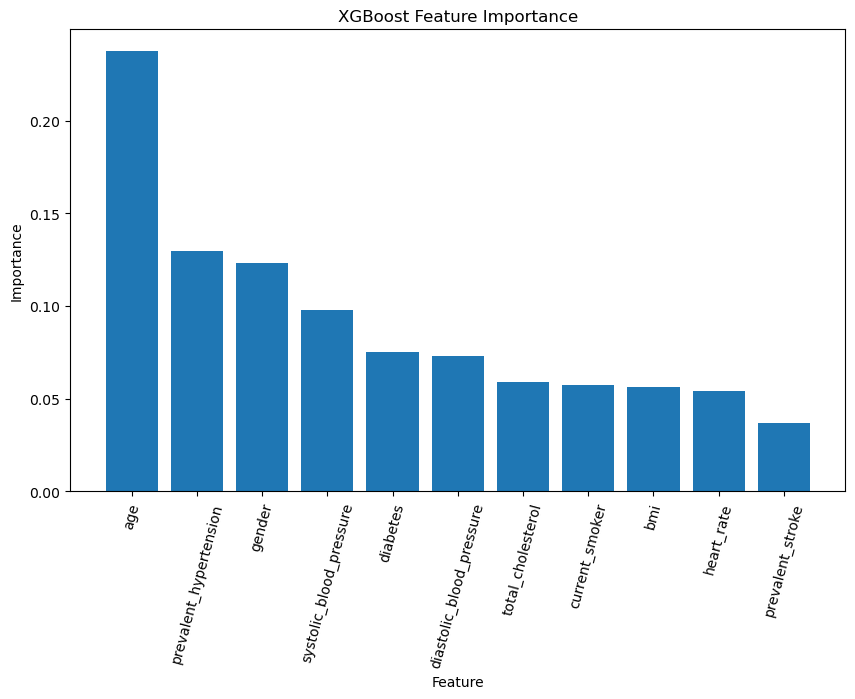

In [166]:
import matplotlib.pyplot as plt

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xticks(rotation=75)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('XGBoost Feature Importance')
plt.show()

In [167]:
from sklearn.model_selection import GridSearchCV

In [168]:
# Step 1: Define the parameter grid to search
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],              # Step size shrinkage used in update to prevent overfitting
    'n_estimators': [50, 100, 200],                 # Number of boosting rounds (trees)
    'max_depth': [3, 5, 7],                         # Maximum depth of a tree
    'min_child_weight': [1, 3, 5],                  # Minimum sum of instance weight needed in a child
    'subsample': [0.8, 1.0],                        # Subsample ratio of the training instances
    'colsample_bytree': [0.8, 1.0],                 # Subsample ratio of columns when constructing each tree
}

In [169]:
# Step 2: Create the XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

In [170]:
# Step 3: Create the GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=5)

In [171]:
# Step 4: Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                        

In [172]:
# Step 5: Get the best hyperparameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


In [173]:
# Step 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [174]:
# Step 1: Create the XGBoost model with the best hyperparameters
best_params = {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3,
               'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42, **best_params)

In [175]:
# Step 2: Train the model on the training data
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

In [176]:
# Step 3: Make predictions on new data
y_pred = xgb_model.predict(X_test)

In [177]:
# Step 4: Evaluate the model (if you have the ground truth labels for the test set)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.8489208633093526
Classification Report:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       708
           1       0.00      0.00      0.00       126

    accuracy                           0.85       834
   macro avg       0.42      0.50      0.46       834
weighted avg       0.72      0.85      0.78       834

Confusion Matrix:
[[708   0]
 [126   0]]


/opt/anaconda3/envs/pythondata/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/pythondata/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/pythondata/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
